In [45]:
import multiprocessing as mp
import numpy as np
import ctypes
import random
import seaborn as sns
import pandas as pd
import time

#### Функция создания общей матрицы, заполненной случайными значениями

In [46]:
def create_matrix ():
    mp_matrix = mp.Array('i', dimension ** 2)
    matrix = np.frombuffer(mp_matrix.get_obj(), ctypes.c_int).reshape(dimension, dimension)
    for i in range(dimension):
        for j in range(dimension):
            matrix[i][j] = random.randint(0, 500)
    return matrix


#### Функции для обычного перемножения двух матриц:

In [47]:
def mul_rows():
    C = np.zeros(dimension**2, ctypes.c_int).reshape(dimension, dimension)
    for i in range(dimension):
        for j in range(dimension):
            for k in range(dimension):
                C[i][j] += A[i][k] * B[k][j]
    return C
def mul_columns():
    C = np.zeros(dimension**2).reshape(dimension, dimension)
    for i in range(dimension):
        for j in range(dimension):
            for k in range(dimension):
                C[j][i] += A[j][k] * B[k][i]
    return C

#### Подсчет времени непараллельного перемножения: по строкам и по столбцам

In [48]:
dimension = 200
A = create_matrix()
B = create_matrix()

time_start = time.time()
C = mul_rows()
time_rows = time.time() - time_start
print("По строкам:", time_rows)

time_start = time.time()
H = mul_columns()
time_columns = time.time() - time_start
print("По столбцам:", time_columns)

По строкам: 9.75678038597107
По столбцам: 6.602080583572388


#### Функция для многопоточного подсчета (каждый процесс считает last_row - first_row + 1 элементов итоговой матрицы)

In [49]:
def mul_process(first_row, last_row):
    for i in range (first_row, last_row + 1):
        for j in range (dimension):
            for k in range(dimension):
                D[i][j] += A[i][k] * B[k][j]

#### Многопоточность достигиается посредством использования структуры multiprocessing.Pool и использования метода starmap_async

In [50]:
times = []
index_list = []
base_times = [time_rows] * 15
for proc_num in range (1, 16):
    index_list.append(proc_num)
    D = mp.Array('i',dimension**2)
    D = np.frombuffer(D.get_obj(), ctypes.c_int).reshape(dimension, dimension)
    part = dimension // proc_num
    remainder = dimension % proc_num
    args = []
    for i in range (0, dimension, part):
        if (i + part - 1) < dimension:
            args.append([i, i + (part-1)])
    args[-1][1]  += remainder
    time_start = time.time()
    pool = mp.Pool(proc_num)
    pool.starmap_async(mul_process, args)
    pool.close()
    pool.join()
    times.append(time.time() - time_start)
    if np.array_equal(C, D):
        print("Подсчет верный")
    else:
        print("Подсчет неверный")
times


Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный
Подсчет верный


[6.168025493621826,
 3.136106252670288,
 2.2112855911254883,
 1.7708172798156738,
 1.98417329788208,
 1.5578629970550537,
 1.6298351287841797,
 1.4500019550323486,
 1.6454846858978271,
 1.4050588607788086,
 1.3716669082641602,
 1.5320594310760498,
 1.4683468341827393,
 1.5658257007598877,
 1.4748356342315674]

,
1,6.168025
2,3.136106
3,2.211286
4,1.770817
5,1.984173
6,1.557863
7,1.629835
8,1.450002
9,1.645485
10,1.405059


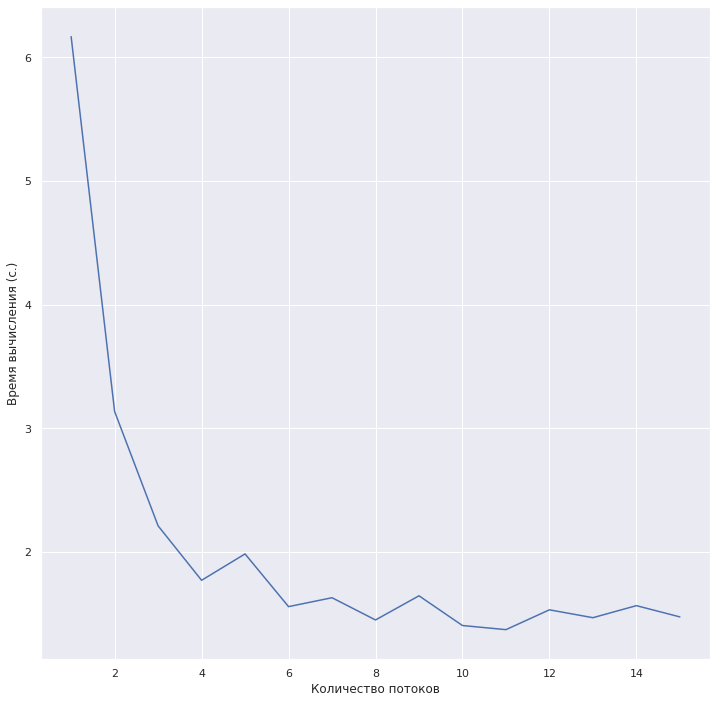

In [82]:
df = pd.DataFrame({
    '': times,
}, index = index_list)
sns.set (rc={'figure.figsize':( 12 , 12 )})
plot = sns.lineplot(data=df)
plot.set(xlabel = "Количество потоков",
        ylabel= "Время вычисления (с.)")
df